[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/subhacom/moose-notebooks/blob/main/More_complex_current_injection_protocol.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/subhacom/moose-notebooks/HEAD)

In [ ]:
## Uncomment below if on colab!
# !pip install pymoose

# Modeling a simple chemical reaction
Physics and chemistry underlie biology. Modeling of electrical activities of neurons involves biophysics. But biochemical processes ultimately decide the properties of the neurons. These biochemical processes in turn may be influenced by the physics of the system. 

The ion channels we modeled in Hodgkin-Huxley squid giant axon simulation are actually proteins that are created by the translation of genetic codes in the DNA. These are chemical processes, and may determine the ion channel density, and hence conductance, in the cell. Receptor channels in neurons and other cells can be controlled by chains of chemical reactions. Various plasticity mechanisms thought to be responsible for memory formation are also results of biochemical signalling. In multiscale models we want to combine these chemical processes with physical processes like electrical activity of neurons.

MOOSE gives you a single framework to combine biochemical models with biophysical models. Here we start with the simplest chemical model.

Let us consider a simple chemical reaction:

$A \longrightarrow C$

Here molecules of A transform into molecules of C. The rate law for the reaction specifies the relationship between the reaction rate (the rate at which A transforms into C) and the concentrations of the participating chemical species. Rate laws are found experimentally and may not be directly related to the stoichiometric equation.

For more detail on reaction rates see this [libretext chapter](https://chem.libretexts.org/Bookshelves/General_Chemistry/Map%3A_Chemistry_-_The_Central_Science_(Brown_et_al.)/14%3A_Chemical_Kinetics)

Let us say, the reaction rate here is proportional to the concentration of A, denoted $[A]$

$v = k [A] $

thus at any point of time the rate of the reaction is proportional to the concentration of species A. $k$ is the rate constant.

Fundamentally, every chemical reaction is reversible. So the transformation of A into C would actually be like:

$A \longrightarrow C$ and $A \longleftarrow C$, or put together: $A \rightleftharpoons C$


The corresponding rate equations could be 
$v_{f} = k_{f} [A]$ and $v_{b} = k_{b} [B]$

To model this reaction in MOOSE we need 

1. a container for the chemicals, or a chemical compartment
2. a pool of molecules of the chemical species A
3. a pool of molecules of the chemical species B
4. a reaction object to hold information about the reaction, including $k_{f}$ and $k_{b}$ rate constants.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moose

In [2]:
model = moose.Neutral('/model')        # model container
comp = moose.CubeMesh('/model/comp')   # chemical compartment

Now create the pools of molecules of the two species

In [3]:
a = moose.Pool(f'{comp.path}/A')
c = moose.Pool(f'{comp.path}/C')

Create the reaction object

In [4]:
reac = moose.Reac(f'{comp.path}/reac')

and connect up the substrate and the product via messages

In [5]:
moose.connect(reac, 'sub', a, 'reac')
moose.connect(reac, 'prd', c, 'reac')

<moose.SingleMsg id=5 dataIndex=1 path=/Msgs[0]/singleMsg[1]>

Now we need a `Stoich` object to setup the stoichiometry matrix for the reaction system. We need to set its `compartment` field to our chemical compartment, and assign a chemical kinetics solver (object of class `Ksolve`) to its `ksolve` field. The `Ksolve` class conducts the calculations to solve the chemical reaction system deterministically (as opposed to stochastically, which should be applied when the number of molecules are so small that the random bouncing of the molecules become apparent in the reaction).

In [6]:
stoich = moose.Stoich( f'{comp.path}/stoich' )
stoich.compartment = comp
ksolve = moose.Ksolve( f'{comp.path}/ksolve' )
stoich.ksolve = ksolve

Finally, we need to set the `reacSystemPath` field of the `Stoich` object to include everything inside our chemical compartment.

In [7]:
stoich.reacSystemPath = f'{comp.path}/##'

We also need a couple of tables to monitor the concentrations of the chemicals. 


In [8]:
data = moose.Neutral('/data')
tabA = moose.Table2(f'{data.path}/A')
tabC = moose.Table2(f'{data.path}/C')
moose.connect(tabA, 'requestOut', a, 'getConc')
moose.connect(tabC, 'requestOut', c, 'getConc')

<moose.SingleMsg id=5 dataIndex=4 path=/Msgs[0]/singleMsg[4]>

*Note that we are using `Table2` instead of `Table` here. `Table2` is updated at a slower interval by default, matching the default update rates of chemical kinetics solvers. We could use `Table` here, but that would have required making the `dt` of the corresponding clock tick slower, or making the `dt` for the clock tick for the `Ksolve` faster.*

Now we set the properties of the components

In [9]:
comp.volume = 1e-21    # the reaction is in a 0.1 um cube
a.concInit = 1.0       # initial concentration
c.concInit = 0.0       # initial concentration
reac.Kf = 0.05         # forward reaction rate
reac.Kb = 0.01         # backward reaction rate

Finally we initialize and run the simulation for 100 s.

In [10]:
moose.reinit()
simtime = 100.0
moose.start(simtime)

And plot the results

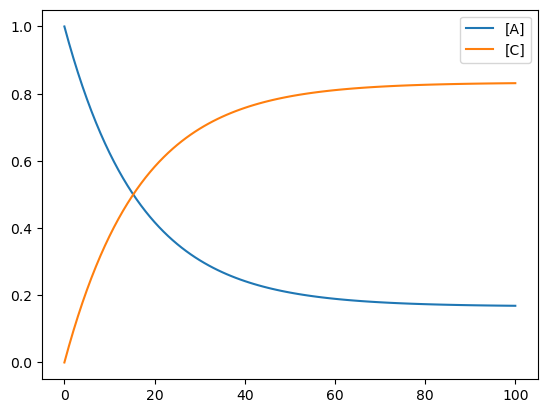

In [11]:
t = np.arange(len(tabA.vector)) * tabA.dt
plt.plot(t, tabA.vector, label='[A]')
plt.plot(t, tabC.vector, label='[C]')
plt.legend()

As we expect intuitively, the concentration of A decreases with time, and that of C increases. Over time, they reach a steady state where the concentrations are such that the rate at which A transforms into C is the same as the rate at which C transforms back to A. 

## Mathematics of the first-order chemical reaction
You may have noticed that the concentration plots look like discharging and charging curves of a capacitor (see the RC circuit in [Getting_started_with_compartmental_modelling_in_MOOSE.ipynb], because the underlying mathematics is the same.

The forward rate, $v_{f}$ is proportional to the concentration of A: $[A]$

$v_{f} = k_{f} [A] $

By definition, $v_{f} = -\frac{d[A]}{dt}$, thus

$\frac{d[A]}{dt} = -k_{f}[A]$


Compare this to the voltage equation for the parallel RC circuit: $C \frac{dV}{dt} = - \frac{V}{R}$ or equivalently, $\frac{dV}{dt} = - \frac{V}{\tau}$.

This is a first-order differential equation with $k_{f}$ constant, and $[A]$ as independent variable. This chemical reaction is also a first-order reaction.

We can rearrange the terms above to get

$\frac{d[A]}{[A]} = - k_{f} dt$


Integrating both sides we get

$\left[ ln([A]) \right]_{[A]_{0}}^{[A]} = \left[- k_{f} t \right]_{0}^{t}$

or $ln([A]) - ln([A]_{0}) = - k_{f} t$

or $ln(\frac{[A]}{[A]_{0}}) = - k_{f} t$

taking exponential of both sides we get:

$\frac{[A]}{[A]_{0}} = e^{- k_{f} t}$

or $[A] = {[A]_{0}} e^{- k_{f} t}$


where $[A]_{0}$ is the initial concentration of A (i.e., at time t = 0).


Similarly, you can calculate the concentration of C over time, which will be similar to the equation for a capacitor charging equation.
